# Trabalho Câncer de pele - Setup

## Importação de bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np

import datetime
import pytz

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

In [3]:
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.resnet import ResNet50, preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from google.colab import userdata, runtime

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

import os

## Setup Kaggle

*   Configuração kaggle
*   Dataset download
*   Listagem de pastas
*   Listagem de Arquivos

In [4]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d ./skin-cancer-dataset/

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:58<00:00, 23.7MB/s]
100% 5.20G/5.20G [03:58<00:00, 23.4MB/s]


## Leitura das informações sobre as imagens do dataset

In [6]:
import pandas as pd
data = pd.read_csv("/content/skin-cancer-dataset/HAM10000_metadata.csv", index_col=None)
display(data.iloc[0:100])

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
95,HAM_0000746,ISIC_0027023,bkl,histo,60.0,male,face
96,HAM_0001473,ISIC_0029022,bkl,histo,70.0,male,face
97,HAM_0003007,ISIC_0025388,bkl,histo,40.0,female,abdomen
98,HAM_0003007,ISIC_0028080,bkl,histo,40.0,female,abdomen


### Análise dos dados
---
*   **Quantidade de idades errada** ❌

In [7]:
display(data.info())
print("-"*50)
display(data.shape)
print("-"*50)
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


None

--------------------------------------------------


(10015, 7)

--------------------------------------------------


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


### Tratamento dos dados

In [8]:
base_dir = '/content/skin-cancer-dataset/classes'
data['image_path'] = data.apply(lambda row: os.path.join(base_dir, row['dx'], f"{row['image_id']}.jpg"),axis=1)
display(data.iloc[0:100])

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin-cancer-dataset/classes/bkl/ISIC_...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin-cancer-dataset/classes/bkl/ISIC_...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin-cancer-dataset/classes/bkl/ISIC_...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/skin-cancer-dataset/classes/bkl/ISIC_...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/skin-cancer-dataset/classes/bkl/ISIC_...
...,...,...,...,...,...,...,...,...
95,HAM_0000746,ISIC_0027023,bkl,histo,60.0,male,face,/content/skin-cancer-dataset/classes/bkl/ISIC_...
96,HAM_0001473,ISIC_0029022,bkl,histo,70.0,male,face,/content/skin-cancer-dataset/classes/bkl/ISIC_...
97,HAM_0003007,ISIC_0025388,bkl,histo,40.0,female,abdomen,/content/skin-cancer-dataset/classes/bkl/ISIC_...
98,HAM_0003007,ISIC_0028080,bkl,histo,40.0,female,abdomen,/content/skin-cancer-dataset/classes/bkl/ISIC_...


## Classes

*    bkl: Benign keratosis-like lesions
*    nv: Melanocytic nevi
*    df: Dermatofibroma
*    mel: Melanoma
*    vasc: Vascular lesions
*    bcc: Basal cell carcinoma
*    akiec: Actinic keratoses

In [9]:
classes = data["dx"].unique()
print(classes)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [10]:
os.makedirs(base_dir, exist_ok=True)

for class_name in classes:
    os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

In [11]:
import shutil
image_folders = [
    '/content/skin-cancer-dataset/HAM10000_images_part_1',
    '/content/skin-cancer-dataset/HAM10000_images_part_2'
]

for index, row in data.iterrows():
    image_found = False
    class_name = row['dx']
    dest_folder = f'{base_dir}/{class_name}'


    for image_folder in image_folders:
        image_file = f'{image_folder}/{row["image_id"]}.jpg'
        if os.path.exists(image_file):
            shutil.move(image_file, f'{dest_folder}/{row["image_id"]}.jpg')
            image_found = True
            break

    if not image_found:
        print(f"Imagem {row['image_id']} não encontrada em nenhuma das pastas.")

print("Imagens organizadas nas pastas correspondentes.")

Imagens organizadas nas pastas correspondentes.


# Classificação do tipo de Câncer de pele - Treinamento

In [12]:
data = data[['dx', 'image_path']]
data

,dx,image_path
0,bkl,/content/skin-cancer-dataset/classes/bkl/ISIC_...
1,bkl,/content/skin-cancer-dataset/classes/bkl/ISIC_...
2,bkl,/content/skin-cancer-dataset/classes/bkl/ISIC_...
3,bkl,/content/skin-cancer-dataset/classes/bkl/ISIC_...
4,bkl,/content/skin-cancer-dataset/classes/bkl/ISIC_...
...,...,...
10010,akiec,/content/skin-cancer-dataset/classes/akiec/ISI...
10011,akiec,/content/skin-cancer-dataset/classes/akiec/ISI...
10012,akiec,/content/skin-cancer-dataset/classes/akiec/ISI...
10013,akiec,/content/skin-cancer-dataset/classes/akiec/ISI...


In [13]:
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data['dx'], random_state=42)

datagen_train = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_data,
    x_col="image_path",
    y_col="dx",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    directory=None
)

val_generator = datagen_val.flow_from_dataframe(
    dataframe=val_data,
    x_col="image_path",
    y_col="dx",
    target_size=(224, 224),
    batch_size=64,
    class_mode="categorical",
    directory=None
)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [22]:

from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import average_precision_score
import tensorflow as tf

# Callback AUC-PR
class AUCPRCallback(Callback):
    def __init__(self, validation_generator):
        super().__init__()
        self.validation_generator = validation_generator

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = next(self.validation_generator)

        y_pred = self.model.predict(x_val)


        try:
            auc_prc = average_precision_score(y_val, y_pred, average='weighted')
            print(f'\nEpoch {epoch + 1}: AUC-PRC = {auc_prc:.4f}')
        except ValueError as e:
            print(f'\nEpoch {epoch + 1}: Error calculating AUC-PRC - {str(e)}')

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Descongelar as últimas camadas do modelo base para permitir fine-tuning
for layer in base_model.layers[:-10]:  # Descongelando as últimas 10 camadas
   layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

# Calcular pesos de classe
class_weights = {i: 1.0 for i in range(len(classes))}

# Callbacks para otimizar o desempenho
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
auc_pr_callback = AUCPRCallback(validation_generator=val_generator)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_AUC', save_best_only=True, mode='max')


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, auc_pr_callback]
)


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step

Epoch 1: AUC-PRC = 0.8142
125/125 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - AUC: 0.8341 - loss: 1.5569 - val_AUC: 0.9270 - val_loss: 0.9451
Epoch 2/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - AUC: 0.8631 - loss: 1.3241

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Epoch 2: AUC-PRC = 0.7638
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 0.8631 - loss: 1.3241 - val_AUC: 0.8631 - val_loss: 1.2437
Epoch 3/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 3: AUC-PRC = 0.7460
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - AUC: 0.8980 - loss: 1.0953 - val_AUC: 0.9329 - val_loss: 0.9147
Epoch 4/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - AUC: 0.9379 - loss: 0.8753

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Epoch 4: AUC-PRC = 0.7401
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - AUC: 0.9379 - loss: 0.8753 - val_AUC: 0.9307 - val_loss: 0.9358
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 5: AUC-PRC = 0.8070
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - AUC: 0.9095 - loss: 1.0288 - val_AUC: 0.9380 - val_loss: 0.9021
Epoch 6/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - AUC: 0.8974 - loss: 1.1133

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 6: AUC-PRC = 0.6885
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8974 - loss: 1.1133 - val_AUC: 0.8813 - val_loss: 1.1760
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 7: AUC-PRC = 0.7947
125/125 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - AUC: 0.9208 - loss: 0.9598 - val_AUC: 0.9399 - val_loss: 0.9016
Epoch 8/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - AUC: 0.8902 - loss: 1.1324

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Epoch 8: AUC-PRC = 0.8342
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - AUC: 0.8902 - loss: 1.1324 - val_AUC: 0.9238 - val_loss: 1.0128
Epoch 9/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 9: AUC-PRC = 0.7888
125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - AUC: 0.9228 - loss: 0.9474 - val_AUC: 0.9415 - val_loss: 0.8600
Epoch 10/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - AUC: 0.9425 - loss: 0.7985

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 10: AUC-PRC = 0.7638
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9425 - loss: 0.7985 - val_AUC: 0.9462 - val_loss: 0.8613
Epoch 11/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 11: AUC-PRC = 0.7702
125/125 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - AUC: 0.9298 - loss: 0.9051 - val_AUC: 0.9432 - val_loss: 0.8522
Epoch 12/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - AUC: 0.9553 - loss: 0.7305

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 12: AUC-PRC = 0.7828
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9553 - loss: 0.7305 - val_AUC: 0.9520 - val_loss: 0.8529
Epoch 13/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 13: AUC-PRC = 0.8620
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - AUC: 0.9322 - loss: 0.8863 - val_AUC: 0.9451 - val_loss: 0.8403
Epoch 14/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - AUC: 0.9074 - loss: 1.0766

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

Epoch 14: AUC-PRC = 0.7952
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - AUC: 0.9074 - loss: 1.0766 - val_AUC: 0.9093 - val_loss: 1.0195
Epoch 15/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 15: AUC-PRC = 0.8543
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - AUC: 0.9295 - loss: 0.9113 - val_AUC: 0.9447 - val_loss: 0.8446
Epoch 16/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - AUC: 0.9626 - loss: 0.6900

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step

Epoch 16: AUC-PRC = 0.7893
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 0.9626 - loss: 0.6900 - val_AUC: 0.9912 - val_loss: 0.5020
Epoch 17/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 17: AUC-PRC = 0.7434
125/125 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - AUC: 0.9349 - loss: 0.8764 - val_AUC: 0.9460 - val_loss: 0.8640
Epoch 18/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - AUC: 0.9497 - loss: 0.7701

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 18: AUC-PRC = 0.7919
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9497 - loss: 0.7701 - val_AUC: 0.9402 - val_loss: 0.8225
Epoch 19/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 19: AUC-PRC = 0.8308
125/125 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - AUC: 0.9328 - loss: 0.8907 - val_AUC: 0.9481 - val_loss: 0.8297
Epoch 20/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - AUC: 0.8974 - loss: 1.1233

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 20: AUC-PRC = 0.7925
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.8974 - loss: 1.1233 - val_AUC: 0.9464 - val_loss: 0.9910
Epoch 21/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 21: AUC-PRC = 0.7968
125/125 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - AUC: 0.9358 - loss: 0.8668 - val_AUC: 0.9480 - val_loss: 0.8128
Epoch 22/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - AUC: 0.9593 - loss: 0.7083

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 22: AUC-PRC = 0.8200
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9593 - loss: 0.7083 - val_AUC: 0.9287 - val_loss: 0.9391
Epoch 23/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 23: AUC-PRC = 0.8475
125/125 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - AUC: 0.9358 - loss: 0.8666 - val_AUC: 0.9494 - val_loss: 0.7871
Epoch 24/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - AUC: 0.9346 - loss: 0.8915

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Epoch 24: AUC-PRC = 0.8023
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9346 - loss: 0.8915 - val_AUC: 0.8883 - val_loss: 1.1886
Epoch 25/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Epoch 25: AUC-PRC = 0.8978
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - AUC: 0.9379 - loss: 0.8605 - val_AUC: 0.9501 - val_loss: 0.7983
Epoch 26/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - AUC: 0.9474 - loss: 0.7725

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 26: AUC-PRC = 0.7577
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9474 - loss: 0.7725 - val_AUC: 0.9492 - val_loss: 0.8260
Epoch 27/30


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Epoch 27: AUC-PRC = 0.8040
125/125 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - AUC: 0.9388 - loss: 0.8494 - val_AUC: 0.9504 - val_loss: 0.7857
Epoch 28/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - AUC: 0.9591 - loss: 0.7103

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Epoch 28: AUC-PRC = 0.7981
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.9591 - loss: 0.7103 - val_AUC: 0.9638 - val_loss: 0.7769
Epoch 29/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Epoch 29: AUC-PRC = 0.8250
125/125 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - AUC: 0.9404 - loss: 0.8379 - val_AUC: 0.9505 - val_loss: 0.7815
Epoch 30/30
  1/125 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - AUC: 0.9436 - loss: 0.7818

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Epoch 30: AUC-PRC = 0.7612
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - AUC: 0.9436 - loss: 0.7818 - val_AUC: 0.9614 - val_loss: 0.7682


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


## Salva o modelo no seu google drive

In [24]:
fuso_horario = pytz.timezone('America/Sao_Paulo')
data_atual_utc_minus3 = datetime.datetime.now(fuso_horario)
data_formatada = data_atual_utc_minus3.strftime('%H_%M-%Y_%m_%d')

model.save("skin_cancer_classification_model.keras")
save_dir = "/content/drive/MyDrive/TrabalhoIA"
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

destino = f"{save_dir}/skin_cancer_classification_model_{data_formatada}.keras"
print(destino)
!cp /content/skin_cancer_classification_model.keras $destino

/content/drive/MyDrive/TrabalhoIA/skin_cancer_classification_model_12_28-2024_11_12.keras


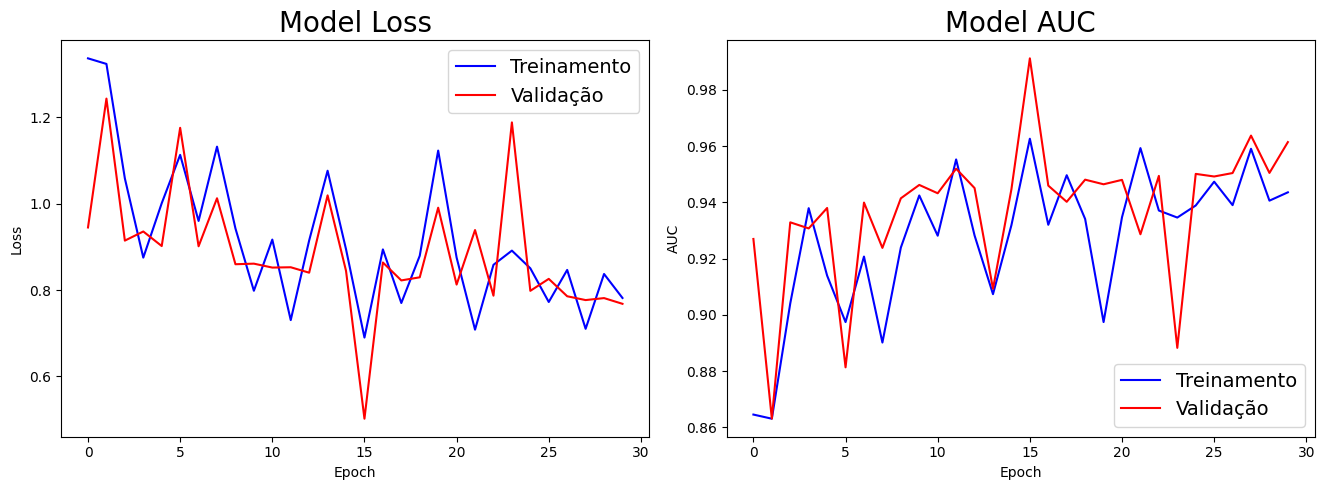

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], color='blue')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)

# AUC
plt.subplot(1, 3, 2)
plt.plot(history.history['AUC'], color='blue')
plt.plot(history.history['val_AUC'], color='red')
plt.title('Model AUC', fontsize=20)
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Treinamento', 'Validação'], loc='lower right', fontsize=14)

# AUC-PR
#plt.subplot(1, 3, 3)
# Aqui é onde o seu AUCPRCallback atualiza o 'pr_auc'
#plt.plot(history.history.get('AUC-PR', []), color='blue')
#plt.plot(history.history.get('val_AUC-PR', []), color='red')
#plt.title('Model AUC-PR', fontsize=20)
#plt.ylabel('AUC-PR')
#plt.xlabel('Epoch')
#plt.legend(['Treinamento', 'Validação'], loc='lower right', fontsize=14)

# Exibindo todos os gráficos
plt.tight_layout()
plt.show()


# Atenção!
## O código abaixo desliga o notebook

In [ ]:

from google.colab import runtime
#runtime.unassign()